# Part 5 WaveNet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [8]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    print(context)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

[0, 8, 15, 12, 4, 1, 14, 0]
torch.Size([182625, 8]) torch.Size([182625])
[0, 0, 8, 1, 25, 12, 1, 0]
torch.Size([22655, 8]) torch.Size([22655])
[0, 25, 15, 22, 1, 14, 9, 0]
torch.Size([22866, 8]) torch.Size([22866])


In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Boilerplate done here.

In [19]:
# Now this is the WaveNet part

In [16]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # the weights using a normal distribution scaled by the square root of fan_in
        # this scaling is also a form of Xavier initialization, which helps in stabilizing the training process.
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 

        # the bias term as zeros if bias is True, otherwise set it to None
        self.bias = torch.zeros(fan_out) if bias else None
  
    # allows the object to be called like a function
    def __call__(self, x):
        # the matrix multiplication of input x with the weight matrix
        self.out = x @ self.weight
        
        # if bias exists, add it to the output
        if self.bias is not None:
            self.out += self.bias
        
        # return the computed output
        return self.out

    # method to return the parameters (weights and bias) of the layer
    def parameters(self):
        # return the weight and bias as a list. If bias is None, only return the weight.
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [30]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # a small constant to avoid division by zero during normalization in the denominator
        self.eps = eps  
        
        self.momentum = momentum  
        
        # flag to indicate whether the layer is in training mode
        self.training = True  
        
        # learnable param
        self.gamma = torch.ones(dim)  # initialized to 1
        self.beta = torch.zeros(dim)  # initialized to 0)
    
        # buffers (not learnable, updated during forward passes)
        self.running_mean = torch.zeros(dim)  # Running mean of the inputs
        self.running_var = torch.ones(dim)  # Running variance of the inputs
  
    def __call__(self, x):
        # calculate the forward pass (normalize the input)
        if self.training:
            # the dimensions over which to compute mean and variance
            # if x is a 2D tensor (e.g., [batch_size, features])
            if x.ndim == 2:  
                dim = 0
            # else if x is a 3D tensor (e.g., [batch_size, time, features])
            elif x.ndim == 3:  
                dim = (0, 1)
            
            # these are the mean and variance across the batch
            # batch mean
            xmean = x.mean(dim, keepdim=True) 
             # batch variance
            xvar = x.var(dim, keepdim=True) 
        else:
            # the running mean and variance during evaluation
            xmean = self.running_mean
            xvar = self.running_var
        
        # normalize the input to have zero mean and unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        
        # scale and shift the normalized input using gamma and beta
        self.out = self.gamma * xhat + self.beta
        
        # update the running mean and variance during training
        if self.training:
            # disable gradient calculation for these updates
            with torch.no_grad():  
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        # return the output of the BatchNorm layer
        return self.out
  
    # method to return the parameters (gamma and beta) of the layer
    def parameters(self):
        return [self.gamma, self.beta]


In [17]:
class Tanh:
    def __call__(self, x):
        # torch.tanh activation function to the input x
        # it squashes the input to the range (-1, 1)
        self.out = torch.tanh(x)
        
        
        
        return self.out
    
    # returns an empty list because the Tanh function has no learnable parameters
    def parameters(self):
        return []


In [18]:
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        # initialize the embedding matrix with random values
        # num_embeddings: the size of the vocabulary (number of unique tokens)
        # embedding_dim: the size of each embedding vector
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        # retrieve the embeddings for the indices provided in IX, which is typically a tensor 
        # containing indices of the words/tokens
        # self.weight[IX] extracts the corresponding embedding vectors for those indices
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        # return the embedding matrix as 
        # the only learnable parameter
        return [self.weight]


In [22]:
class FlattenConsecutive:
  
    def __init__(self, n):
        # n specifies how many consecutive time steps or elements to flatten together
        self.n = n
        
    def __call__(self, x):
        # get the batch size (B), 
        # sequence length (T), 
        # and number of features (C) from the input tensor x
        B, T, C = x.shape
        
        # reshape the input tensor x by flattening n consecutive elements together
        # the new shape is (B, T//self.n, C*self.n)
        # T//self.n gives the new sequence length after flattening
        # C*self.n gives the new number of features after flattening
        x = x.view(B, T//self.n, C*self.n)
        
        # remove that dimension, if the length is 1
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        # for later
        self.out = x
        
        return self.out
  
    def parameters(self):
        # return an empty list as this layer has no learnable parameters
        return []


In [24]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [25]:
torch.manual_seed(42) 

In [31]:
# Andrej's notes:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [32]:
# same optimization as previously
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2993
  10000/ 200000: 2.0000
  20000/ 200000: 1.9776
  30000/ 200000: 2.1607
  40000/ 200000: 1.9803
  50000/ 200000: 1.9390
  60000/ 200000: 1.9556
  70000/ 200000: 2.1118
  80000/ 200000: 2.5469
  90000/ 200000: 1.5931
 100000/ 200000: 1.9002
 110000/ 200000: 2.1456
 120000/ 200000: 1.3915
 130000/ 200000: 1.4755
 140000/ 200000: 1.7937
 150000/ 200000: 1.6296
 160000/ 200000: 2.1320
 170000/ 200000: 1.6626
 180000/ 200000: 2.0077
 190000/ 200000: 1.4109


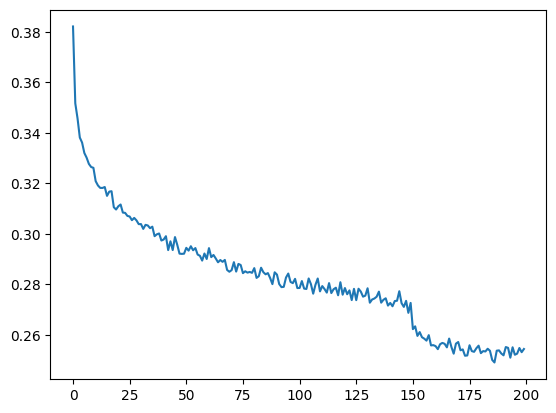

In [33]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [34]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [35]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.766425609588623
val 1.9937143325805664


In [36]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        
        
        
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mattie.
amiri.
raella.
emeri.
ronielo.
sammi.
kaleiah.
mckenson.
belmady.
samyah.
kassaya.
brenneite.
gunceri.
nangell.
tyleigh.
rosalera.
taivika.
alhissa.
mayonnie.
ally.
